# 智能推荐系统第二次作业代码

## Model-based CF for Recommended Items

10215001419 宋朝芸

### LFM

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
### 模型训练与预测

def load_and_split(train_path, test_path, test_size=0.2, random_state=None, choice = 0):
  # 加载csv数据集为pd数据框
  train = pd.read_csv(train_path)
  test = pd.read_csv(test_path)
  # 转为user-item矩阵
  train_df = train.pivot(index='user_id',columns='item_id',values=['rating']) 
  # 模型选择步
  if (choice == 0):
    # 加载pd数据框用于surprise包
    reader = Reader(rating_scale=(1, 10))
    load_train = Dataset.load_from_df(train, reader)
    # surprise包进行数据划分
    _, validset = train_test_split(load_train, test_size=test_size, random_state=random_state)

    # 遍历validset，更新train_df和valid_df
    for row in validset:
        userid, itemid, rate = row
        # 将valid_set中出现的值设为nan
        train_df.iloc[userid, itemid] = float('nan')
    
    # 为了便于计算ndsg，转为df
    valid_df = pd.DataFrame(validset, columns=['user_id', 'item_id', 'rating'])
    valid_df = valid_df.sort_values(by=['user_id', 'rating'],ascending=[True, False])
    return train_df, valid_df, test
  
  # 结果预测步
  if(choice == 1):
     return train_df, test
  
def LFM_model(matrix, k_size=5, max_iter=2000, alpha=0.0002, normlam=0.002, epsilon=0.001, random = 0):
    # 初始化用户特征矩阵和物品特征矩阵
    m_size = len(matrix)
    n_size = len(matrix[0])
    if(random == 0):
      np.random.seed(123)
    P = np.random.rand(m_size, k_size)
    if(random == 0):
      np.random.seed(456)
    Q = np.random.rand(n_size, k_size).T
    
    # 梯度下降，更新参数
    for _ in tqdm(range(max_iter)):
        # 计算梯度值
        grad = 0
        # 遍历所有的(user,item)对
        for u in range(m_size):
            for i in range(n_size):
                # 如果存在评分，计算评分误差（稍后将用于导数）
                if not np.isnan(matrix[u][i]):
                    error = np.dot(P[u, :], Q[:, i]) - matrix[u][i]
                    # 对特征向量求导，更新梯度下降后的结果
                    for k in range(k_size):
                        grad_p = alpha * 2 * (error * Q[k][i] + normlam * P[u][k])
                        grad_q = alpha * 2 * (error * P[u][k] + normlam * Q[k][i])
                        P[u][k] = P[u][k] - grad_p
                        Q[k][i] = Q[k][i] - grad_q
                        grad = 2*grad_p + 2*grad_q
        # 判断是否达到收敛条件（梯度足够小）
        if grad < epsilon**2:
            break
  
    # 计算预测矩阵
    pred_Mat = np.dot(P,Q)
    print(grad)
    return pred_Mat, grad

def evaluate_model(valid_dataframe, pred_Mat):
    real_rank_list = valid_dataframe["item_id"].values
    real_rate_list = valid_dataframe["rating"].values
    pred_rank_list = []
    pred_rate_list = []

    for _,row in valid_dataframe.iterrows():
        pred_rate_list.append(pred_Mat[int(row['user_id']),int(row['item_id'])])

    valid_dataframe['pred'] = pred_rate_list
    valid_dataframe = valid_dataframe.sort_values(by=['user_id', 'pred'],ascending=[True, False])
    pred_rank_list = valid_dataframe["item_id"].values

    ndcg = ndcg_score(np.asarray([real_rank_list]), np.asarray([pred_rank_list]))
    mse = mean_squared_error(np.asarray([real_rate_list]), np.asarray([pred_rate_list]))
    return ndcg, mse

def pred_result(test_dataframe, pred_Mat, savepath):
    # 预测得分
    pred_list = []
    for _,row in test_dataframe.iterrows():
        pred_list.append(pred_Mat[row['user_id'],row['item_id']])#预测
    test_dataframe['rating'] = pred_list

    # 按要求排序
    test_dataframe = test_dataframe.sort_values(by=['user_id', 'rating'],ascending=[True, False])
    result = test_dataframe.iloc[:,:2]
    result.reset_index(drop=True, inplace=True)
    result.insert(0, "id", result.index)
    result.to_csv(savepath,index = False,header=True)
    return result


In [4]:
### 参数搜索
def search_paras(train_dataframe, valid_dataframe, ks, normlams, max_iter = 500, alpha = 0.02, epsilon = 0.01):  
  # 初始化RMSE矩阵为空矩阵
  MSE_out = []
  NDCG_out = []
  grad_out = []
  # 遍历参数列表计算RMSE
  for k in ks:
    MSE_in = []
    NDCG_in = []
    grad_in = []
    for normlam in normlams:
      pred_Mat,grad = LFM_model(np.array(train_dataframe), k, max_iter, alpha, normlam, epsilon, random=0)
      ndcg, mse = evaluate_model(valid_dataframe, pred_Mat)
      MSE_in.append(mse)
      NDCG_in.append(ndcg)
      grad_in.append(grad)
    
    MSE_out.append(MSE_in)
    NDCG_out.append(NDCG_in)
    grad_out.append(grad_in)

  return MSE_out,NDCG_out,grad_out

##### 保存矩阵参数搜索结果为csv
def save_grids(k, normlam, mses, ndcgs, grads, path):
  df_1 = pd.DataFrame(mses, index=k, columns=normlam)
  df_1.index.name = 'k'
  df_1.columns.name = 'normlam'
  df_1.to_csv(path+"_mse.csv")

  df_2 = pd.DataFrame(ndcgs, index=k, columns=normlam)
  df_2.index.name = 'k'
  df_2.columns.name = 'normlam'
  df_2.to_csv(path+"_ndcg.csv")

  df_3 = pd.DataFrame(grads, index=k, columns=normlam)
  df_3.index.name = 'k'
  df_3.columns.name = 'normlam'
  df_3.to_csv(path+"_grad.csv")

##### 读取某一次训练结果csv
def read_grid(path):
  df = pd.read_csv(path, index_col=0)
  k = df.index.tolist()
  thres = df.columns.tolist()
  # 移除 k 和 threshold 行、列，保留原始的数据结构
  df.index.name = None
  df.columns.name = None

  return k, thres, np.array(df)

In [5]:
### NDCG和MSE的可视化

##### RMSE矩阵热力图
def draw_confusion_matrix(
        cm, label_x, label_y, threshold, evalutation = "RMSE", title = "", pdf_save_path=None, dpi=300):
    
    # 显示数据
    plt.imshow(cm, cmap='GnBu')
    plt.title(evalutation+" Confusion Matrix"+title)
    plt.xlabel('Lambda', fontsize=14)
    plt.ylabel('k', fontsize=14)
    plt.yticks(range(label_y.__len__()), label_y, fontsize = 15)
    plt.xticks(range(label_x.__len__()), label_x, rotation=45, fontsize = 15)
    plt.tight_layout()
    plt.colorbar(label=evalutation)
    
    # 根据数值大小决定标签颜色，为了防止深色处看不见
    for i in range(label_x.__len__()):
        for j in range(label_y.__len__()):
            color = "black"
            value = float(format('%.4f' % cm[j, i]))
            if(value >= threshold):
              color = "white"
            plt.text(i, j, value, verticalalignment='center', horizontalalignment='center', color=color,
            fontsize = 15)
    
    # 存储
    if not pdf_save_path is None:
        plt.savefig(pdf_save_path, bbox_inches='tight', dpi=dpi)

##### RMSE矩阵折线图
def draw_line(ks, lambdas, rmses, save_path=None, evaluation = 'RMSE'):
    
    # 显示数据
    plt.figure(figsize=(5, 5))
    for i, k in enumerate(ks):
        plt.plot(lambdas, rmses[i], label=f'k={k}')
    plt.xlabel('Lambda', fontsize=15)
    plt.ylabel(evaluation, fontsize=15)
    plt.title(evaluation+' vs. Lambda for Different k Values')
    plt.legend(fontsize=15)

    # 存储
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=500)


#### 尝试一次

In [28]:
# 读入数据
train_path = "train_.csv"
test_path = "test.csv"
test_size = 0.2
random_state = 42

# 划分数据
train_dataframe, valid_dataframe, test = load_and_split(1682, train_path, test_path, test_size, random_state, choice = 0)

In [6]:
K= 20
max_iter = 1
alpha = 0.02
normlam = 0.01
epsilon = 0.01

pred_Mat,grad = LFM_model(np.array(train_dataframe), K, max_iter, alpha, normlam, epsilon)

100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


In [40]:
ndcg, mse = evaluate_model(valid_dataframe, pred_Mat)
print("ndcg: ",ndcg)
print("mse: ",mse)

save_path = "test.csv"
pred_result(test, pred_Mat, save_path)

ndcg:  0.9137044389110991
mse:  1.1768332344506796


,id,user_id,item_id
0,0,1,189
1,1,1,265
2,2,1,61
3,3,1,171
4,4,1,33
...,...,...,...
9423,9423,943,570
9424,9424,943,215
9425,9425,943,356
9426,9426,943,186


#### 选参数

In [6]:
# 读入数据
train_path = "train_.csv"
test_path = "test.csv"
test_size = 0.2
random_state = 42

# 划分数据
train_dataframe, valid_dataframe, test = load_and_split(train_path, test_path, test_size, random_state, choice = 0)

##### 实验一

In [17]:
###exp 1
k_values = [40, 70, 100]
normlam_values = [0.01, 0.1, 0.5]
file = "exp1"

MSE1, NDCG1, grad1= search_paras(train_dataframe, valid_dataframe, k_values, normlam_values, max_iter = 200, alpha = 0.02, epsilon = 0.001)
save_grids(k_values, normlam_values, MSE1, NDCG1, grad1, file)

  0%|          | 0/200 [00:03<?, ?it/s]


KeyboardInterrupt: 

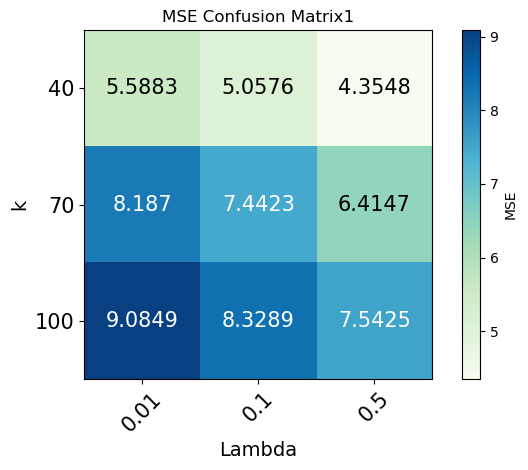

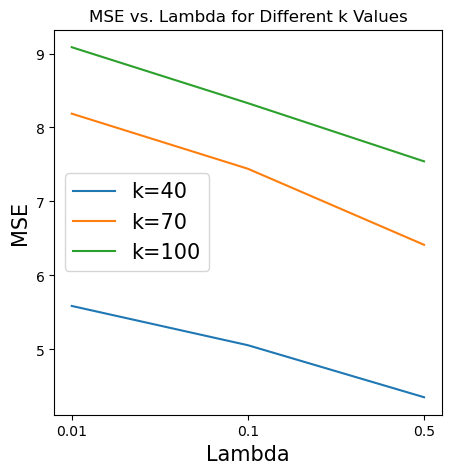

In [29]:
# 实验一的mse
k_values, threshold_values, rmse_results = read_grid('exp1_mse.csv')

draw_confusion_matrix(rmse_results,
                      label_x = threshold_values,
                      label_y = k_values,
                      evalutation="MSE",
                      title="1",
                      pdf_save_path="Confusion_mse_1.png",
                      dpi=300,
                      threshold = 7)

draw_line(k_values, threshold_values, rmse_results, save_path="Lines_mse_1.png", evaluation='MSE')

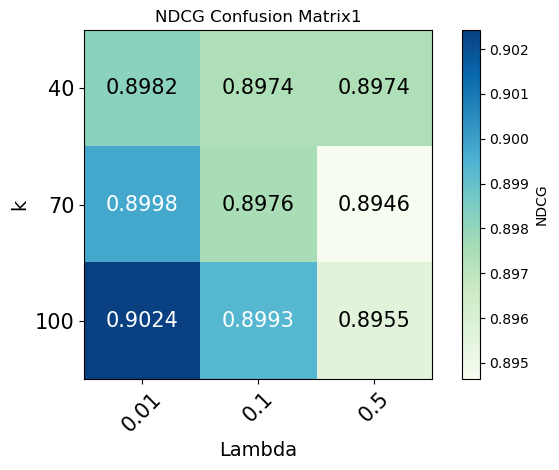

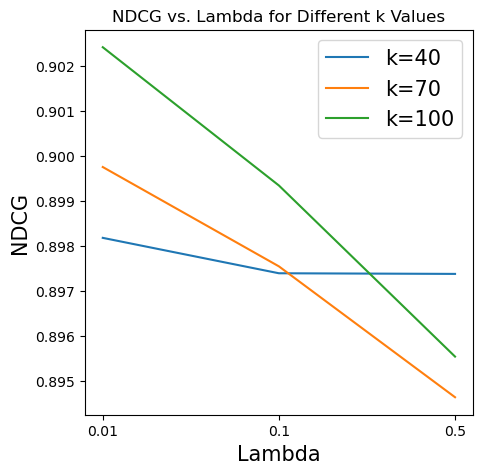

In [34]:
# 实验一的ndcg
k_values, threshold_values, rmse_results = read_grid('exp1_ndcg.csv')

draw_confusion_matrix(rmse_results,
                      label_x = threshold_values,
                      label_y = k_values,
                      evalutation="NDCG",
                      title="1",
                      pdf_save_path="Confusion_ndcg_1.png",
                      dpi=300,
                      threshold = 0.899)

draw_line(k_values, threshold_values, rmse_results, save_path="Lines_ndcg_1.png", evaluation='NDCG')

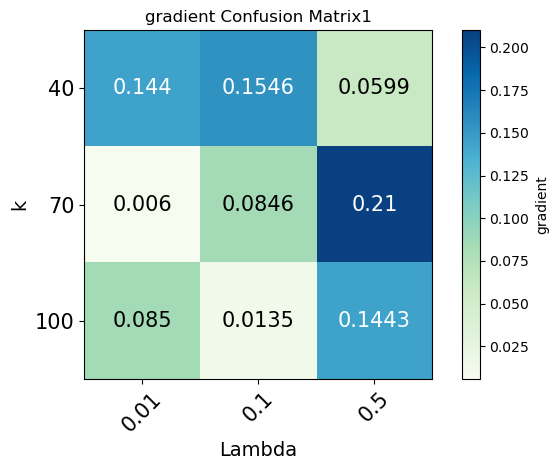

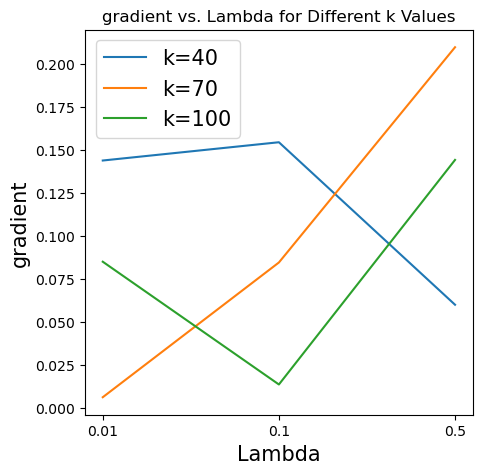

In [44]:
# 实验一的grad
k_values, threshold_values, rmse_results = read_grid('exp1_grad.csv')

draw_confusion_matrix(rmse_results,
                      label_x = threshold_values,
                      label_y = k_values,
                      evalutation="gradient",
                      title="1",
                      pdf_save_path="Confusion_grad_1.png",
                      dpi=300,
                      threshold = 0.11)

draw_line(k_values, threshold_values, rmse_results, save_path="Lines_grad_1.png", evaluation='gradient')

##### 实验二

In [8]:
# ###exp 2
k_values = [20, 40, 70]
normlam_values = [0.01, 0.1]
file = "exp2"

MSE1, NDCG1, grad1= search_paras(train_dataframe, valid_dataframe, k_values, normlam_values, max_iter = 200, alpha = 0.01, epsilon = 0.001)
save_grids(k_values, normlam_values, MSE1, NDCG1, grad1, file)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [40:58<00:00, 12.29s/it] 


0.0022946610850277356


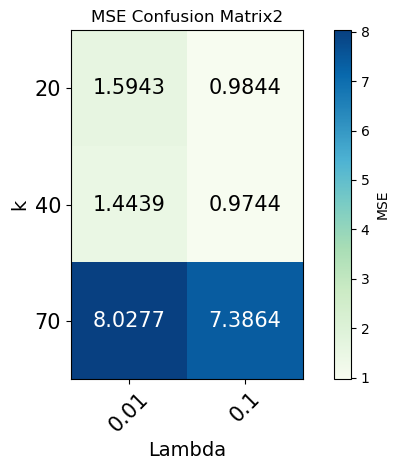

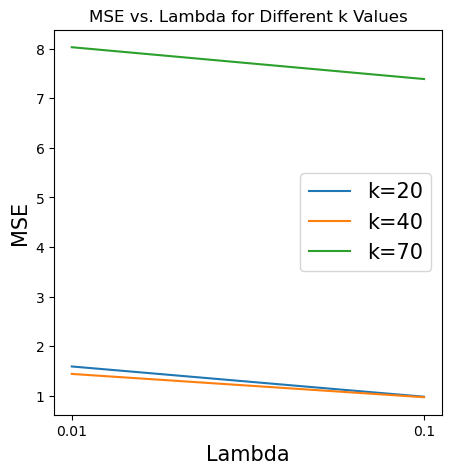

In [37]:
# 实验二的mse
k_values, threshold_values, rmse_results = read_grid('exp2_mse.csv')

draw_confusion_matrix(rmse_results,
                      label_x = threshold_values,
                      label_y = k_values,
                      evalutation="MSE",
                      title="2",
                      pdf_save_path="Confusion_mse_2.png",
                      dpi=300,
                      threshold = 5)

draw_line(k_values, threshold_values, rmse_results, save_path="Lines_mse_2.png", evaluation='MSE')

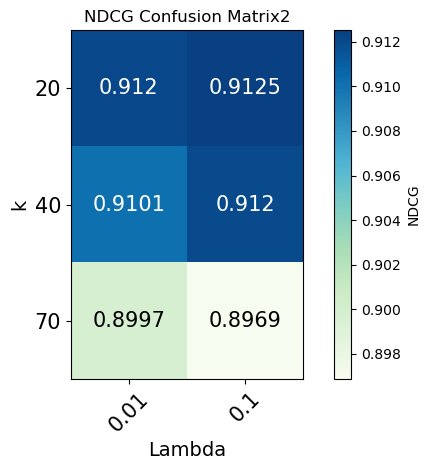

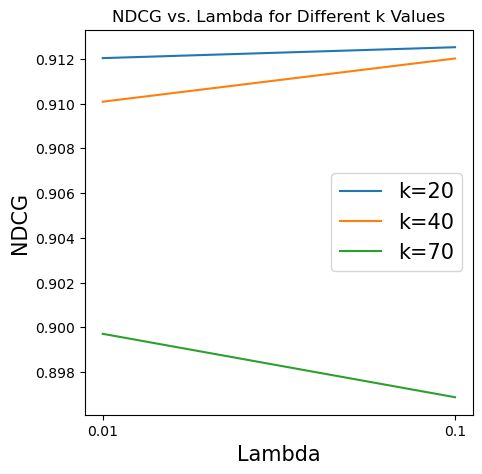

In [39]:
# 实验二的ndcg
k_values, threshold_values, rmse_results = read_grid('exp2_ndcg.csv')

draw_confusion_matrix(rmse_results,
                      label_x = threshold_values,
                      label_y = k_values,
                      evalutation="NDCG",
                      title="2",
                      pdf_save_path="Confusion_ndcg_2.png",
                      dpi=300,
                      threshold = 0.9)

draw_line(k_values, threshold_values, rmse_results, save_path="Lines_ndcg_2.png", evaluation='NDCG')

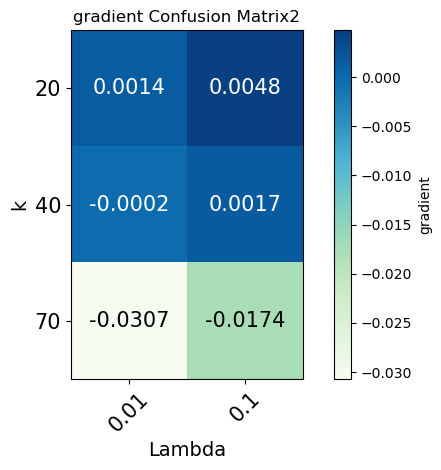

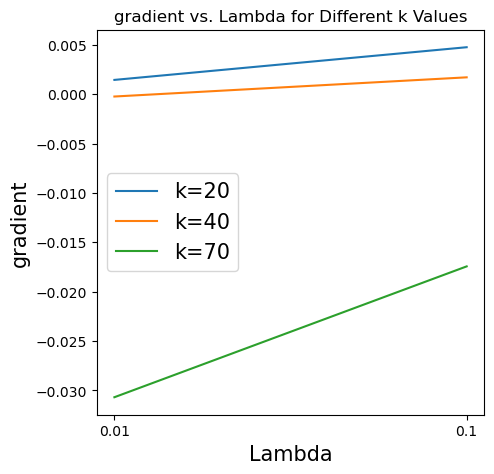

In [43]:
# 实验二的grad
k_values, threshold_values, rmse_results = read_grid('exp2_grad.csv')

draw_confusion_matrix(rmse_results,
                      label_x = threshold_values,
                      label_y = k_values,
                      evalutation="gradient",
                      title="2",
                      pdf_save_path="Confusion_grad_2.png",
                      dpi=300,
                      threshold = -0.01)

draw_line(k_values, threshold_values, rmse_results, save_path="Lines_grad_2.png", evaluation='gradient')

#### 预测

In [5]:
# 读入数据
train_path = "train_.csv"
test_path = "test.csv"
test_size = 0.2
random_state = 42
train_dataframe, valid_dataframe, test = load_and_split(1682, train_path, test_path, test_size, random_state, choice = 0)
train_dataframe, test = load_and_split(1682, train_path, test_path, test_size, random_state, choice = 1)

In [6]:
K= 20
max_iter = 500
alpha = 0.001
normlam = 0.1
epsilon = 0.001
save_path = "output_svd_"+str(K)+"_"+str(normlam)+".csv"

pred_Mat = LFM_model(np.array(train_dataframe), K, max_iter, alpha, normlam, epsilon, random=1)

 18%|█▊        | 89/500 [11:55<55:03,  8.04s/it]  

-1.257846153620437e-05


In [8]:
print(save_path)
pred_result(test, pred_Mat[0], save_path)

output_svd_20_0.1.csv


,id,user_id,item_id
0,0,1,189
1,1,1,61
2,2,1,171
3,3,1,265
4,4,1,202
...,...,...,...
9423,9423,943,356
9424,9424,943,1067
9425,9425,943,232
9426,9426,943,570


### BPR

In [12]:
import numpy as np
import pandas as pd
import torch
import random
from collections import defaultdict

In [15]:
## 数据处理
def load_data(data_path):
    user_ratings = defaultdict(dict)
    max_u_id = -1
    max_i_id = -1
    with open(data_path, 'r') as f:
        next(f)  # 跳过标题行
        for line in f.readlines():
            u, i, r = line.strip().split(',')
            u = int(u)
            i = int(i)
            r = int(r)
            # 存为user-item评分矩阵
            user_ratings[u][i] = r
            max_u_id = max(u, max_u_id)
            max_i_id = max(i, max_i_id)
    return max_u_id, max_i_id, user_ratings

def generate_test(user_ratings):
    user_test = dict()
    # 对每一个user
    for u, i_dict in user_ratings.items():
        # 如果item评分字典非空
        if i_dict:
            # 随机选择验证集
            user_test[u] = random.choice(list(i_dict.keys()))
    return user_test

def generate_train_batch(user_ratings, user_ratings_test, item_count, batch_size=512):
    t = []
    # 对一个batch
    for _ in range(batch_size):
        # 随机选择user
        u = random.choice(list(user_ratings.keys()))
        # 随机选择正item
        i = random.choice(list(user_ratings[u].keys()))
        while i == user_ratings_test[u]:
            i = random.choice(list(user_ratings[u].keys()))
        # 随机选择负item
        j = random.randint(1, item_count)
        while j in user_ratings[u]:
            j = random.randint(1, item_count)
        t.append([u, i, j])
    return np.array(t)

def generate_test_batch(user_ratings, user_ratings_test, item_count):
    # 对每一个user
    for u in user_ratings.keys():
        t = []
        # 记录其测试集的item
        i = user_ratings_test[u]
        # 对于不在测试数据中的item
        for j in range(1, item_count):
            if j not in user_ratings[u]:
                t.append([u, i, j])
        yield np.array(t)

## 预测函数
def predict_one_rating(user_id, item_id):
    uid = user_id
    iid = item_id
    return torch.matmul(P[uid], Q[iid]).item()

In [16]:
data_path = "train_.csv"
user_count, item_count, user_ratings = load_data(data_path)
user_ratings_test = generate_test(user_ratings)

hidden_dim = 20
num_epochs = 50
batch_size = 512
num_batchs = 2000

# 创建叶子节点张量并将其转移到 GPU
P = torch.nn.Parameter(torch.rand((user_count+1,hidden_dim),dtype=torch.float32))
Q = torch.nn.Parameter(torch.rand((item_count+1,hidden_dim),dtype=torch.float32))
optimizer = torch.optim.SGD([P,Q], lr=0.01, momentum=0.9)

In [ ]:
for epoch_idx in range(num_epochs):
    loss_mean = 0
    
    # 遍历每个batch
    for batch_idx in range(num_batchs):
        # 生成训练数据的batch
        uij = generate_train_batch(user_ratings, user_ratings_test, item_count, batch_size=batch_size)
        u, i, j = torch.tensor(uij[:, 0], dtype=torch.int64), torch.tensor(uij[:, 1], dtype=torch.int64), torch.tensor(uij[:, 2], dtype=torch.int64)
        
        # 取出用户、正样本、负样本在特征矩阵上的取值
        u_emb = P[u]
        i_emb = Q[i]
        j_emb = Q[j]
        
        # 梯度清零
        optimizer.zero_grad()
        # 计算BPR损失（梯度上升）
        bprloss = -torch.mean(torch.log(torch.sigmoid(torch.sum(u_emb * (i_emb - j_emb), dim=1))))
        # 反向传播
        bprloss.backward()
        # 更新参数
        optimizer.step()
        # 计算当前batch的损失
        loss_mean += bprloss.item()
    
    preds = []
    
    # 遍历测试数据的batch
    for uij_test in generate_test_batch(user_ratings, user_ratings_test, item_count):
        u, i, j = torch.tensor(uij_test[:, 0], dtype=torch.int64), torch.tensor(uij_test[:, 1], dtype=torch.int64), torch.tensor(uij_test[:, 2], dtype=torch.int64)
        
        # 取出用户、正样本、负样本在特征矩阵上的取值
        u_emb = P[u]
        i_emb = Q[i]
        j_emb = Q[j]
        
        # 计算预测评分
        pred = torch.sigmoid(torch.sum(u_emb * (i_emb - j_emb), dim=1))
        preds.extend(pred.tolist())
    
    # 计算NDCG和准确率
    preds_num = len(preds)
    preds_array = np.array(preds)
    ndcg = ndcg_score([preds_array], [np.zeros_like(preds_array)])
    accuracy = len([v for v in preds if v >= 0.5]) / preds_num
    
    # 打印当前epoch的损失、准确率和NDCG
    print("Epoch {}, loss:{}, acc:{}, ndcg:{}".format(epoch_idx, loss_mean / num_batchs, accuracy, ndcg))

In [11]:
## 输出预测结果
user_ratings_pred = pd.read_csv("test.csv")

predict_result = []
for index, row in user_ratings_pred.iterrows():
     predict_result.append(predict_one_rating(user_ratings_pred.iloc[index,0], user_ratings_pred.iloc[index,1]))

user_ratings_pred['rating'] = predict_result
user_ratings_pred = user_ratings_pred.sort_values(by=['user_id', 'rating'],ascending=[True, False])
result = user_ratings_pred.iloc[:,:2]
result.reset_index(drop=True, inplace=True)
result.insert(0, "id", result.index)
result.to_csv("output_bpr_simple.csv",index = False,header=True)

### UCF

In [19]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [20]:
### 基于用户

#### pearson相关系数矩阵
def pearson_sim_matrix(dat):
  # 用户相似度，需要把用户作为列（转置）
  temp = dat.transpose()
  return temp.corr()  


#### 选择最相似的k个用户
def select_neighbor(dat, uid, iid, k, thres, mean, sim):  
  # 获取与用户u相似度大于阈值的用户列表
  neighbors = np.where(sim[uid] > thres)[0]
  # 获取对商品i评分过的用户列表及其对应的评分和相似度
  neighbors_info = [(v, dat.iloc[v, iid], sim.iloc[uid, v], mean.iloc[v]) for v in neighbors 
                    if (not np.isnan(dat.iloc[v, iid]) 
                        and (not np.isnan(sim.iloc[v,uid]))
                        and (sim.iloc[v,uid] > thres) )]
  # 根据与用户u的相似度降序排序
  neighbors_info.sort(key=lambda x: x[2], reverse=True)
  # 获取最大的k个相似用户及其对应的dat取值和sim取值
  neighbors_info = neighbors_info[:k]
  if(len(neighbors_info) == 0):
    user = rating = sim = mean = 0
  else:
    user, rating, sim, mean = zip(*neighbors_info)
  return user, rating, sim, mean


#### 进行预测
def predict_rate(dat, uid, iid, k, threshold, mean, sim):
  # 计算近邻集合
  _, knn_ratings, knn_sim, knn_mean = select_neighbor(dat, uid, iid, k, threshold, mean, sim)
  # 计算预测值
  pred = mean[uid] + np.sum((np.array(knn_ratings) - np.array(knn_mean)) * np.array(knn_sim)) / (np.sum(knn_sim)+1)

  return pred

#### 计算验证集RMSE
def RMSE_calculate(train_set, validset, k, threshold):  
  # 计算用户均分和用户相似度矩阵
  mean = train_set.mean(axis = 1, skipna = True)
  sim = pearson_sim_matrix(train_set)
  # 初始化空列表存储非空元素的预测值和真实值
  predicted_values = []
  true_values = []
  # 遍历验证集进行预测
  for row in validset:
    uid, iid, rate = row
    pred = predict_rate(train_set, uid, iid, k, threshold, mean, sim)
    predicted_values.append(pred)
    true_values.append(rate)
  # 计算RMSE
  mse = mean_squared_error(true_values, predicted_values)
  rmse = np.sqrt(mse)
  
  return rmse, true_values, predicted_values


#### 读取并划分数据
def load_and_split(train_path, test_path, test_size=0.2, random_state=None, choice = 0):
  # 加载csv数据集为pd数据框
  train = pd.read_csv(train_path)
  test = pd.read_csv(test_path)
  # 转为user-item矩阵
  train_df = train.pivot(index='user_id',columns='item_id',values=['rating'])

  # 模型选择步
  if (choice == 0):
    # 加载pd数据框用于surprise包
    reader = Reader(rating_scale=(1, 10))
    load_train = Dataset.load_from_df(train, reader)
    # surprise包进行数据划分
    _, validset = train_test_split(load_train, test_size=test_size, random_state=random_state)
    # 初始化train_set为user-item矩阵
    train_set = train_df.copy()
    # 遍历validset，更新train_set和valid_df
    for row in validset:
        userid, itemid, rate = row
        # 在train_set中将valid_set中出现的值设为nan
        train_set.iloc[userid, itemid] = float('nan') 
    return train_set, validset, test
  
  # 结果预测步
  if(choice == 1):
     return train_df, test

#### 输出结果

In [ ]:
# 读入数据
train_path = "train_.csv"
test_path = "test.csv"
test_size = 0.2
random_state = 42

# 划分数据
train_dataframe, test_dataframe = load_and_split(train_path, test_path, test_size, random_state, choice = 1)

# 设定参数
k = 50
threshold = 0.1

# 计算一些后续要用到的东西
train_mean = train_dataframe.mean(axis = 1, skipna = True)
train_sim = pearson_sim_matrix(train_dataframe)

In [24]:
def predict_rates(row):
  # 对每一行调用predict_rate
  pred = predict_rate(train_dataframe, row["user_id"], row["item_id"], k, threshold, train_mean, train_sim)
  return pred

def predict_testset(testset):  
  # 对每一行进行预测
  testset['rating'] = testset.apply(predict_rates, axis=1)
  testset = testset.sort_values(by=['user_id', 'rating'],ascending=[True, False])
  result = testset.iloc[:,:2]
  result.reset_index(drop=True, inplace=True)
  result.insert(0, "id", result.index)
  result.to_csv("output_icf.csv",index = False,header=True)
  return testset

In [ ]:
ucf_result = predict_testset(test_dataframe)